# MST Vincolato
Dato un grafo non orientato e non completo, e dato un nodo r, si determini l’albero di copertura di radice r che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha ki ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di ki-1)

In [32]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from random import seed, randint
import time

In [33]:
# PARAMETRI GENERALI
OUT_DIR = "out/tabu" # dove salvare i disegni dei grafi (x debug)

ROOT_NODE = 5
MAX_NODES = 66
GRAPH_GENERATOR = "NOT_BEST_PATH" # [NX_ATLAS | NX_COMPLETE | NX_DENSE | NX_RANDOM | DENSE | SPARSE | NOT_BEST_PATH ]
RANDOM_SEED = 191295

### Inizializzazione

In [34]:
# CREAZIONE GRAFO e strutture

# TODO importa grafo da file


# Grafo di test
if not "GRAPH_GENERATOR" in globals():
    GRAPH_GENERATOR = "CUSTOM"
else :
    match GRAPH_GENERATOR:
        case "NX_ATLAS": 
            # generatore "atlas" di networkx
            # non sono grafi molto densi, e sono piccoli
            # 666
            # 420
            # 969
            # 1196
            atlas_num = 969
            print("[INFO] Uso generatore nx.atlas (seed={})".format(atlas_num))
            G = nx.graph_atlas(atlas_num)

        case "NX_COMPLETE":
            print("[INFO] Uso generatore grafo completo (n={})".format(MAX_NODES))
            G = nx.complete_graph(range(1,MAX_NODES+1))

        case "NX_DENSE":
            n = MAX_NODES
            m = 2*int(n*(n-2)/3)
            print("[INFO] Uso generatore grafo denso (n={}, m={})".format(n,m))
            if "RANDOM_SEED" in globals():
                seed = RANDOM_SEED
            else:
                print("[WARN] Random seed non impostato. Verrà scelto a caso")
                seed = None
                
            G = nx.dense_gnm_random_graph(n, m, seed=seed)

        case "NX_RANDOM":
            G = nx.random_regular_graph(d=MAX_NODES%10, n=MAX_NODES)

        
        case "DENSE":
            print("[INFO] Uso generatore mio DENSE")
            G = nx.Graph()
            G.add_nodes_from([
                x for x in range(1, MAX_NODES+1)
            ])

            G.add_edges_from([
                (x,y) for x in range(1, MAX_NODES+1)
                    for y in range(x+1, MAX_NODES+1)
            ])

            # Rendiamo il grafo non completo
            G.remove_edges_from([ (1,4), (3,6), (5,3), (4,5)])
            G.remove_edges_from([ 
                (a,b) for a in range(MAX_NODES, int(MAX_NODES/2))
                      for b in [x for x in range(1,MAX_NODES-1) if (b+a) %3 != 0]
            ])

        case "SPARSE":
            n = MAX_NODES
            m = 3#3*int(n*(n/2)/10)
            print("[INFO] Uso generatore SPARSE (Barabasi-Albert, n={}, m={})".format(n,m))
            if "RANDOM_SEED" in globals():
                seed = RANDOM_SEED
            else:
                print("[WARN] Random seed non impostato. Verrà scelto a caso")
                seed = None
                
            G = nx.barabasi_albert_graph(n=n, m=m, seed=seed)

        case "NOT_BEST_PATH":
            G = nx.barabasi_albert_graph(n=int(MAX_NODES/2), m=6, seed=RANDOM_SEED)

            # Rendi impossibile trovare un percorso di lunghezza 0
            # aggiungendo nodi raggiungibili solo da uno stesso nodo
            n = len(G.nodes)
            #G.add_edges_from([(ROOT_NODE,x) for x in range(n, n + 5)]) # dummy

            # v.2 by prof. Nonato
            # come sopra ma pensato meglio
            n_0 = n
            star_count = 0
            seed(RANDOM_SEED)
            while n < MAX_NODES:
                n_star = min(MAX_NODES-n,5)
                star = nx.generators.star_graph(range(n,n+n_star))
                link_node = randint(0,n_0)
                G.add_edges_from(star.edges)
                G.add_edge(link_node, n)

                n += n_star
                star_count += 1

            print("[INFO] Aggiunte ",star_count, " stelle al grafo di partenza.")

            
        case _:
            # robetta semplice
            atlas_num = 1234
            print("[WARN] Generatore non valido, uso grafo di test (nx.atlas, id=1234)")
            G = nx.graph_atlas(atlas_num)

# Prepara directory in cui salvare i rendering
OUT_DIR = os.path.join(os.getcwd(),OUT_DIR)
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

[INFO] Aggiunte  7  stelle al grafo di partenza.


In [35]:
# Alcune funzioni di supporto

def draw_graph(graph, MST=nx.empty_graph(), root_node=None):
    # adapted from:
    # https://stackoverflow.com/questions/60164893/highlighting-certain-nodes-edges-in-networkx-issues-with-using-zip

    nodes_shared_options = {"node_size": 500, "edgecolors": "black", "linewidths": 1.2}
    edges_shared_options = {"connectionstyle": 'arc3', "width": 1.25} 
    
    # Get position using spring layout
    pos = nx.spring_layout(graph, seed=54321)
    #pos = nx.circular_layout(graph)

    # Get MST path
    path_edges = list(MST.edges)

    # Prepare the figure size
    plt.figure(figsize=(max(8,MAX_NODES/6),max(8,MAX_NODES/6)))

    # Draw nodes and edges not included in the MST path
    #nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes)-set(MST.nodes))
    nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes, node_color="whitesmoke", **nodes_shared_options)
    nx.draw_networkx_edges(graph, pos, edgelist=set(graph.edges)-set(path_edges), edge_color='gray', **edges_shared_options )

    # Draw MST path
    # highlight the root node
    if root_node != None:
        nx.draw_networkx_nodes(graph, pos, nodelist=[root_node], node_color='tab:red', **nodes_shared_options)

    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', **edges_shared_options)

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_color='black', font_weight='bold')
    nx.draw_networkx_labels(graph, pos, labels={root_node: root_node}, font_color='whitesmoke', font_weight='bold')



def save_figure(name, format="svg"):
    filename = "{}.{}".format(name,format)
    plt.tight_layout(pad=1)
    plt.savefig(os.path.join(OUT_DIR,filename), bbox_inches='tight', format=format, dpi=800, transparent=True)



In [36]:
# Funzione obiettivo

def cost(MST, root_node=ROOT_NODE, debug=False):

    if debug:
        print("root node: ",root_node)

    support_graph = nx.Graph()

    visited = set()
    next = [root_node]
    
    cost = 0

    while len(next) > 0:
        node = next.pop(0)
        node_edges = MST.edges(node)
        
        if node not in visited:
            k_children = len( [ x for x in node_edges if x not in support_graph.edges ] )

            if debug:
                print("node {} has {} children".format(node, k_children))

            if k_children > 1:
                cost += k_children - 1

            visited.add(node)
            next = next + list(MST.adj[node])
            support_graph.add_edges_from(node_edges)
        
    return cost


root node:  1
node 1 has 2 children
node 2 has 3 children
node 6 has 0 children
node 3 has 0 children
node 5 has 0 children
node 4 has 0 children
cost:  3


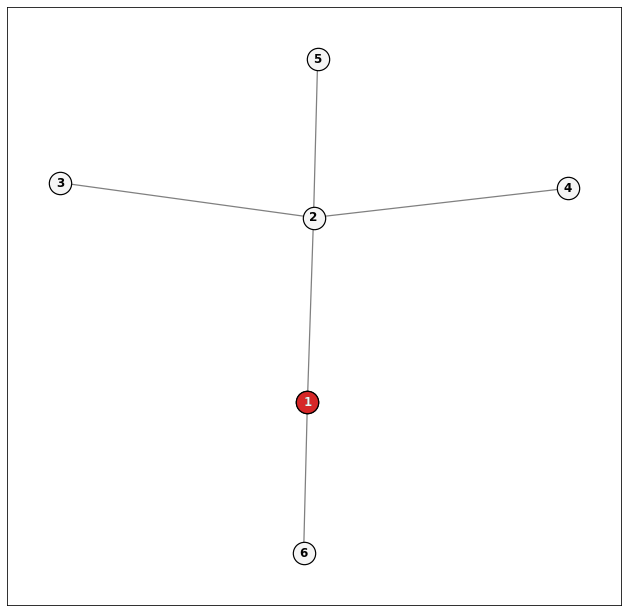

In [37]:
# TEST cost() children nodes
TEST = nx.Graph()
TEST.add_edges_from([(1, 2), (2, 3), (2, 5), (1, 6), (2, 4)])

TEST_ROOT = 1

draw_graph(TEST, root_node=TEST_ROOT)

print("cost: ",cost(TEST, root_node=TEST_ROOT, debug=True))

## Tabu Search

In [38]:
# PARAMETRI RICERCA
TABU_SIZE = 15      
MAX_ITER = 36000            # arresta la ricerca dopo queste iterazioni (es. se il grafo è troppo grosso)
MAX_ITER_SAME_COST = 2500   # max. iterazioni su uno stallo

# [Debug]
DEBUG_IMPROVEMENT = False
SAVE_STEP_GRAPHS = False    

### 1. Creazione soluzione ammissibile

Parto da un MST subottimale ottenuto con Kruskal/Prim o la visita in ampiezza a partire dalla radice.

In [39]:
# Creazione di MST ammissibile con radice specificata tramite visita in ampiezza
def build_rooted_mst(graph, root_node):
    visited_nodes = set() # per evitare cicli
    next_visit = []

    MST = nx.Graph()

    #MST.add_node(n1) # non necessario, aggiunti in automatico con gli archi

    #next_visit = list(G.adj[root_node]) # inserisci i vicini del nodo di partenza

    next_visit.insert(0,root_node) # assicurati di partire dal nodo radice!
    #for n in next_visit:
    while len(next_visit) > 0:
        n = next_visit.pop(0)
        # processa un nodo solo se non è già stato visitato
        if n not in visited_nodes:
            visited_nodes.add(n)
            # aggiungi i suoi vicini non visitati alla lista/stack di visita
            unvisited_neighbourhood = [x for x in list(G.adj[n]) if x not in visited_nodes]
            #print("n = ",n)
            #print("unvisited_neighbourhood = ",unvisited_neighbourhood)
            #print("(before loop) next_visit = ",next_visit)
            # inserimento in testa -> depth first?
            next_visit = unvisited_neighbourhood + next_visit
            for neighbour in unvisited_neighbourhood:
                if neighbour not in MST.nodes:
                    #print("MST edge added: ", (n,neighbour))
                    MST.add_edge(n,neighbour)
            #print("(after loop) next_visit = ",next_visit) 
        #else:
            #print("n = ", n, "(ignored)")

    return MST

In [40]:
# Creazione soluzione iniziale
#mst = build_rooted_mst(G, ROOT_NODE)
mst = nx.algorithms.minimum_spanning_tree(G, algorithm="prim")

In [41]:
# PRINT INFO SOL. INIZIALE
print("Costo iniziale:", cost(mst, ROOT_NODE))
print("MST = ", mst.edges)

print("")
print("---DETTAGLI---")
V = G.number_of_nodes()
E = G.number_of_edges()
print("Generatore: ",GRAPH_GENERATOR)
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("graph is complete: ",(E == V*(V-1)/2))

Costo iniziale: 47
MST =  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 17), (0, 18), (0, 19), (0, 20), (0, 28), (0, 29), (0, 31), (1, 24), (1, 33), (2, 21), (2, 22), (2, 25), (2, 27), (2, 63), (3, 23), (3, 26), (3, 30), (4, 16), (7, 15), (9, 32), (11, 48), (11, 53), (13, 43), (13, 58), (20, 38), (33, 34), (33, 35), (33, 36), (33, 37), (38, 39), (38, 40), (38, 41), (38, 42), (43, 44), (43, 45), (43, 46), (43, 47), (48, 49), (48, 50), (48, 51), (48, 52), (53, 54), (53, 55), (53, 56), (53, 57), (58, 59), (58, 60), (58, 61), (58, 62), (63, 64), (63, 65)]

---DETTAGLI---
Generatore:  NOT_BEST_PATH
|V| =  66
|E| =  195

---TEST AMMISSIBILITA'---
graph is complete:  False


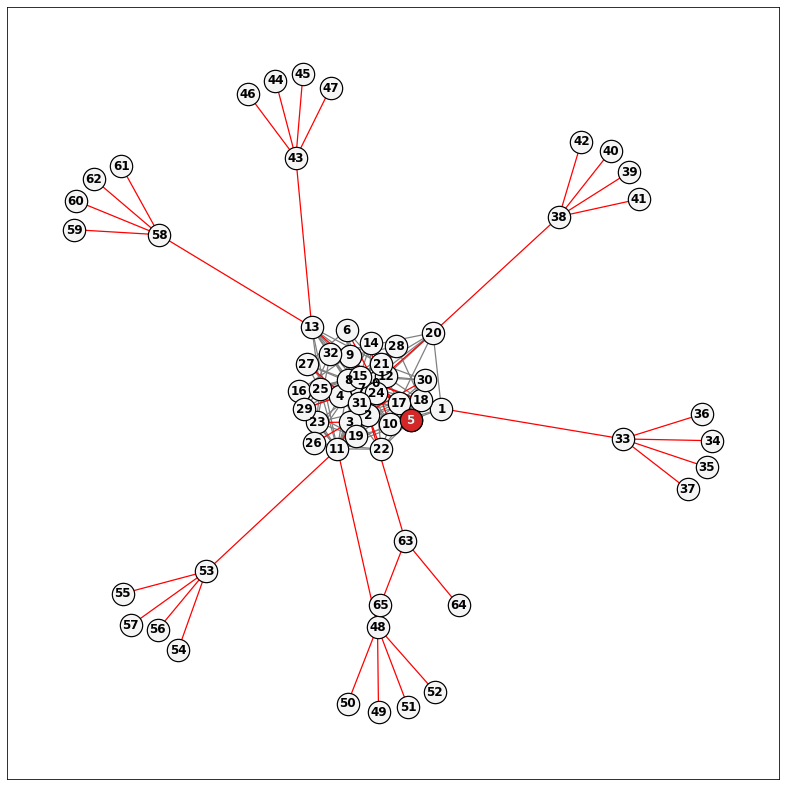

In [42]:
# RENDERING MST INIZIALE SUL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="initial")

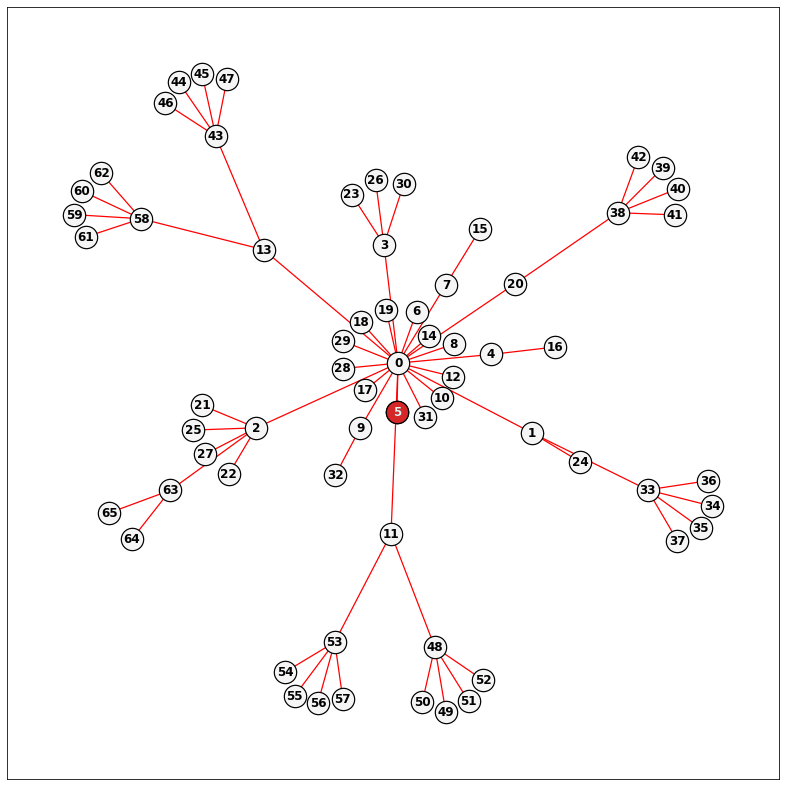

In [43]:
# RENDERING MST INIZIALE
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_initial")

### 2. Improvement

Ad ogni iterazione memorizza in una lista tabu l’inversa della mossa appena effettuata, che resterà proibita per le prossime `TABU_SIZE` iterazioni.

Garantisce che un arco inserito in soluzione con un'operazione di scambio possa essere rimosso solo su una soluzione ormai sostanzialmente diversa da quella originata dalla mossa che l'ha inserito. In questo modo la ricerca non torna facilmente sui suoi passi.

In [44]:
def tabu_search(G, start_solution):
    # compatibilità vecchio codice
    mst = start_solution 

    # calcolo il grafo complementare all'MST
    outer_G = G.copy()
    outer_G.remove_edges_from(mst.edges)
    #draw_graph(outer_G, root_node=ROOT_NODE)

    # Sostituti candidati = archi che possono sostituire quelli in soluzione
    # Uso questa lista per non dover ricalcolare outer_G a ogni iterazione
    out_candidates = list(outer_G.edges)

    # La tabu list evita di sprecare troppe iterazioni 
    # processando sempre gli stessi archi
    tabu_list = []

    global iter; iter = 0

    if DEBUG_IMPROVEMENT:
        print("NON IN MST:", outer_G.edges)
        print("MST:", mst.edges)

        plt.figure(0)
        plt.title("Initial")
        draw_graph(G, mst, root_node=ROOT_NODE)
        if "SAVE_STEPS_GRAPH" in globals() and SAVE_STEPS_GRAPH:
            plt.savefig( os.path.join(OUT_DIR, "debug_Steps",'iter_{}'.format(iter)) )

    S_best = nx.Graph()
    S_best.add_edges_from(list(mst.edges))
    cost_best = cost(S_best)

    global iters_since_last_improvement
    iters_since_last_improvement = 0
    while iter < MAX_ITER and iters_since_last_improvement < MAX_ITER_SAME_COST:
        iter += 1
        
        new_e = out_candidates.pop(0)
        # Assicurati che l'arco estratto non sia stato (re)inserito 
        # nell'MST dopo la sua rimozione da un'altra mossa
        # (questa cosa serve solo perchè non ricreo il grafo complementare a ogni iterazione)
        while new_e in mst.edges:
            if len(out_candidates) == 0:
                break
            new_e = out_candidates.pop(0)

        cost_before = cost(mst)

        # Se sono così fortunato da aver trovato la soluzione ottima,
        # ferma tutto (non si può mai migliorare più di così)
        if cost_before == 0:
            break
        if DEBUG_IMPROVEMENT:
            print("")
            print(k,") initial cost: ",cost_before)
            print("MST=", list(mst.edges))
            print("add: ",new_e)

        mst.add_edges_from([new_e])

        # loop detection
        try:
            loop_edges = nx.algorithms.cycles.find_cycle(mst)
        except:
            print("[ERR]","iter=",iter, "add:{} non ha creato un ciclo".format(new_e))



        # Esplorazione intorno
        Moves = []
        move_k = None
        for e in [x for x in loop_edges if (x != new_e)]:
            temp = mst.copy()
            temp.remove_edges_from([e])
            
            cost_after = cost(temp, ROOT_NODE)
            
            step = (cost_after, e)
            Moves.append(step)

            # Smetti di esplorare appena trovi una mossa migliorativa
            # OK perchè scambiando archi il massimo decremento di costo è 1
            # per ogni iterazione
            if cost_after < cost_before:
                move_k = step
                break
            
        # Se non hai trovato mosse che migliorano la soluzione
        # prendi la meno peggio
        if move_k == None:
            Moves.sort()
            move_k = Moves.pop(0) # ordina in base al costo e prende la prima mossa
        cost_k = move_k[0]
        out_e = move_k[1]
        
        # applico la mossa -> genero S_k
        mst.add_edges_from([new_e])
        mst.remove_edges_from([out_e])

        if DEBUG_IMPROVEMENT:
            fig = plt.figure(iter)
            plt.title("add: {}, remove: {}".format(new_e, out_e))
            draw_graph(mst, mst, root_node=ROOT_NODE )
            if "SAVE_STEP_GRAPHS" in globals() and SAVE_STEP_GRAPHS:
                plt.savefig(os.path.join(OUT_DIR,"debug_Steps",'iter_{}'.format(iter)))
            print("remove: ", out_e)


        if cost_k < cost_best:
            # Ho trovato una mossa migliorativa
            # la soluzione attuale è la nuova sol. migliore
            S_best = mst.copy()
            cost_best = cost_k

            # L'arco che non entra in soluzione deve tornare
            # nel grafo complementare
            out_candidates.append(out_e)

            iters_since_last_improvement = 0
        else:
            iters_since_last_improvement += 1

            if cost_k <= cost_before and (out_e not in tabu_list):
                # La mossa migliore non è proibita (non esploro mosse proibite)
                # ma non abbassa il costo della soluzione.
                # Continuo a esplorare
                # 
                if len(tabu_list) == TABU_SIZE:
                    e = tabu_list.pop(0)
                    out_candidates.append(e)
                tabu_list.append(new_e) # è proibito rimuovere il nuovo arco

                tabu_list.pop(0)


                out_candidates.append(out_e)
            else:
                # Sto peggiorando o facendo cose proibite che non vanno bene,
                # annulla tutto
                mst.remove_edges_from([new_e])
                mst.add_edges_from([out_e])

                out_candidates.append(new_e) # lo metto in fondo per provare a fare altri scambi prima di ripescarlo


    return S_best

In [45]:
start_time = time.time()
mst = tabu_search(G, start_solution=mst)
end_time = time.time()

### 3. Risultati


In [46]:
# PRINT RESULTS
print("Costo finale: ", cost(mst, ROOT_NODE))
print("MST = ",mst.edges)

print("")
print("---DETTAGLI---")
print("Iterazioni complessive eseguite: {}/{}".format(iter,MAX_ITER))
print("Iterazioni eseguite dall'ultimo miglioramento di funzione obiettivo: {}/{}".format(iters_since_last_improvement ,MAX_ITER_SAME_COST))
print("Stallo raggiunto: ", iters_since_last_improvement >= MAX_ITER_SAME_COST)
print("Nodi non ottimali (nodo: n. figli): ",[{n: x-(ROOT_NODE!=n)*1} for (n,x) in mst.degree() if x > 2])
V = G.number_of_nodes()
E = G.number_of_edges()
print("Generatore: ",GRAPH_GENERATOR)
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("grafo è completo: ",(E == V*(V-1)/2))

print("soluzione è un albero: ",nx.is_tree(mst))

try:
    cycletest = nx.algorithms.cycles.find_cycle(mst, orientation="ignore")
except:
    cycletest = None
finally:
    print("cicli in soluzione: ", cycletest)


Costo finale:  25
MST =  [(0, 11), (0, 10), (0, 20), (1, 33), (1, 8), (2, 63), (2, 17), (3, 23), (3, 30), (4, 27), (4, 17), (5, 19), (6, 12), (6, 27), (7, 16), (7, 24), (8, 14), (9, 28), (9, 31), (10, 15), (11, 48), (11, 53), (11, 21), (12, 25), (13, 43), (13, 58), (13, 24), (14, 15), (15, 26), (16, 23), (18, 22), (18, 28), (19, 29), (20, 38), (20, 32), (21, 30), (22, 26), (25, 31), (29, 32), (33, 34), (33, 35), (33, 36), (33, 37), (38, 39), (38, 40), (38, 41), (38, 42), (43, 44), (43, 45), (43, 46), (43, 47), (48, 49), (48, 50), (48, 51), (48, 52), (53, 54), (53, 55), (53, 56), (53, 57), (58, 59), (58, 60), (58, 61), (58, 62), (63, 64), (63, 65)]

---DETTAGLI---
Iterazioni complessive eseguite: 36000/36000
Iterazioni eseguite dall'ultimo miglioramento di funzione obiettivo: 35860/36000
Stallo raggiunto:  False
Nodi non ottimali (nodo: n. figli):  [{0: 2}, {11: 3}, {13: 2}, {15: 2}, {20: 2}, {33: 4}, {38: 4}, {43: 4}, {48: 4}, {53: 4}, {58: 4}, {63: 2}]
Generatore:  NOT_BEST_PATH
|V| =

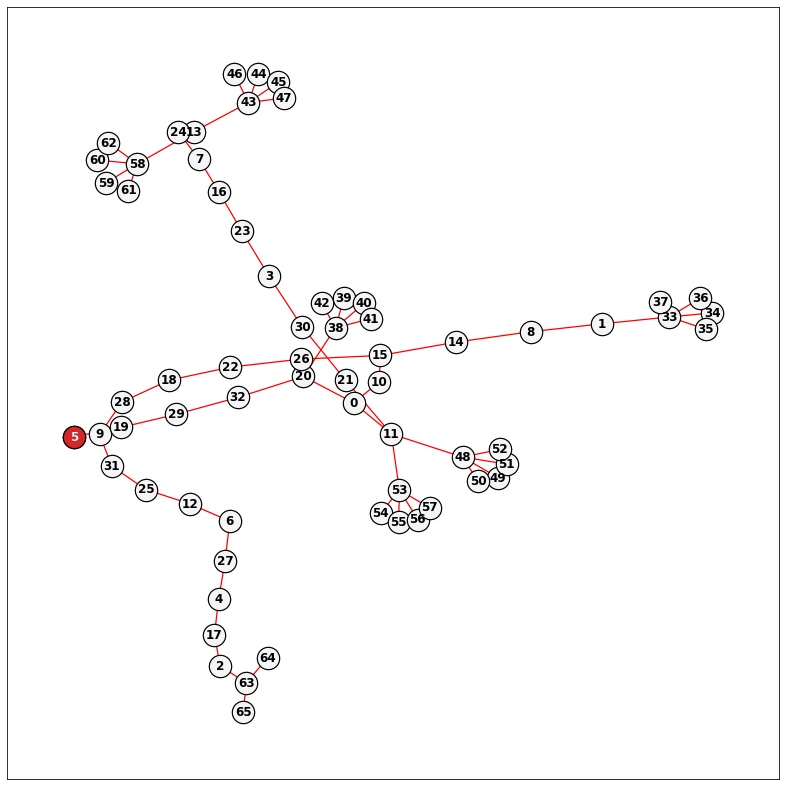

In [47]:
# RENDERING MST
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_final")

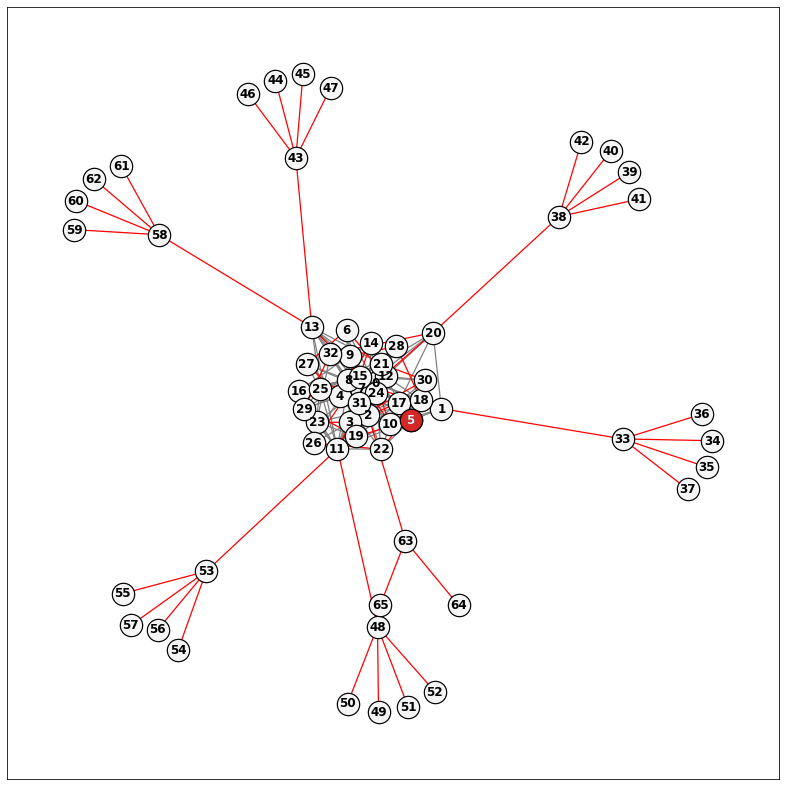

In [48]:
# RENDERING MST SOPRA AL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="final")

In [49]:
from plyer import notification

notification_message = """
Found a solution with cost {}
Elapsed time: {:.2f}s
Iterations completed: {}/{} in

""".format(
        cost(mst, ROOT_NODE),
        (end_time-start_time),
        iter, MAX_ITER,OUT_DIR
    )

notification.notify(
    title="MST computation finished",
    message=notification_message,#"Found a solution with cost {}".format(cost(mst, ROOT_NODE)),
    app_name="ProgettoRO",
    #app_icon="python.exe",
    timeout=15
)